[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/arvidl/ELMED219-2026/blob/main/Lab3-GenAI-LLM/notebooks/02-transformer-arkitektur.ipynb)

# Transformer-arkitekturen: Grunnlaget for moderne AI

**ELMED219 / BMED365 - Lab 3**

---

## Læringsmål

Etter denne notebooken skal du kunne:
- Forstå self-attention mekanismen
- Visualisere hvordan transformers prosesserer tekst
- Koble arkitekturen til praktisk bruk i helsevesenet

## Innhold

1. [Miljøoppsett](#1-miljøoppsett)
2. [Hva er Attention?](#2-hva-er-attention)
3. [Self-Attention i praksis](#3-self-attention-i-praksis)
4. [Multi-Head Attention](#4-multi-head-attention)
5. [Transformer-blokken](#5-transformer-blokken)
6. [Praktisk betydning for helsevesenet](#6-praktisk-betydning-for-helsevesenet)

---

## 1. Miljøoppsett

Koden fungerer både lokalt og i Google Colab.

In [1]:
import sys
import os

# Sjekk om vi kjører i Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Kjører i Google Colab")
    # Installer nødvendige pakker
    !pip install seaborn torch --quiet
else:
    print("Kjører i lokalt miljø")

# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch for transformer-demonstrasjon
try:
    import torch
    import torch.nn as nn
    TORCH_AVAILABLE = True
    print(f"PyTorch versjon: {torch.__version__}")
except ImportError:
    TORCH_AVAILABLE = False
    print("PyTorch ikke tilgjengelig - noen eksempler vil ikke kjøre")

print("Miljø er konfigurert og klart!")

Kjører i lokalt miljø
PyTorch versjon: 2.6.0
Miljø er konfigurert og klart!


---

## 2. Hva er Attention?

**Attention** er en mekanisme som lar modellen fokusere på relevante deler av input-sekvensen når den behandler hvert element.

### Intuisjonen

Tenk deg at du leser setningen:

> "Pasienten har alvorlig diabetes, og **hun** trenger insulinbehandling."

For å forstå hvem "hun" refererer til, må du se tilbake på "pasienten". Dette er essensielt det attention gjør - den lar modellen "se tilbake" og koble sammen relevante deler av teksten.

### Matematisk grunnlag

Attention beregnes med tre komponenter:
- **Query (Q)**: Hva vi leter etter
- **Key (K)**: Hva hvert element "tilbyr"
- **Value (V)**: Innholdet som returneres

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

---

## 3. Self-Attention i praksis

La oss implementere en forenklet versjon av attention for å forstå hvordan det fungerer.

In [2]:
def simple_attention(query, keys, values):
    """
    Forenklet attention-mekanisme.
    
    Args:
        query: Vektor vi søker med
        keys: Matrise med nøkler å sammenligne mot
        values: Matrise med verdier å returnere
    
    Returns:
        output: Vektet sum av values
        weights: Attention-vektene
    """
    # Beregn likhet mellom query og keys (dot product)
    scores = np.dot(query, keys.T)
    
    # Normaliser med softmax for å få sannsynligheter
    weights = np.exp(scores) / np.sum(np.exp(scores))
    
    # Vektet sum av values
    output = np.dot(weights, values)
    
    return output, weights

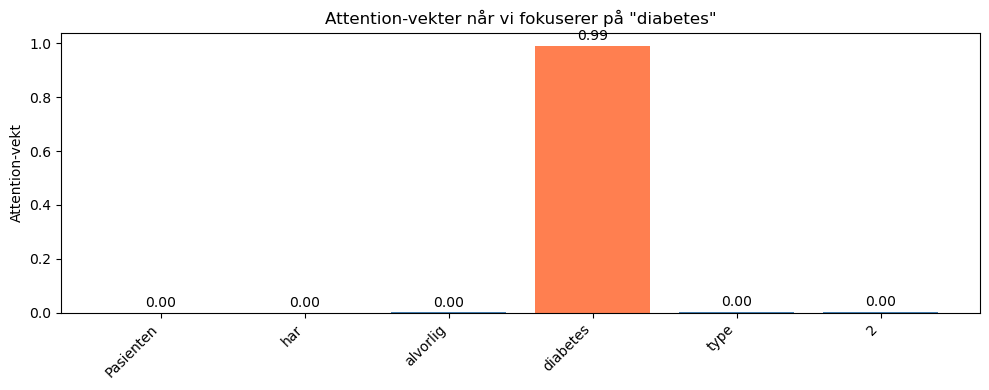


Høyest attention: 'diabetes'
Nest høyest: 'type'


In [3]:
# Eksempel: Medisinsk setning
words = ["Pasienten", "har", "alvorlig", "diabetes", "type", "2"]

# Simuler word embeddings (i praksis ville disse komme fra en trent modell)
np.random.seed(42)  # For reproduserbarhet
embedding_dim = 4
word_embeddings = np.random.randn(len(words), embedding_dim)

# La oss finne attention for ordet "diabetes" (indeks 3)
query_idx = 3
query = word_embeddings[query_idx]

# Beregn attention
output, attention_weights = simple_attention(query, word_embeddings, word_embeddings)

# Visualiser attention-vektene
plt.figure(figsize=(10, 4))
colors = ['steelblue' if i != query_idx else 'coral' for i in range(len(words))]
bars = plt.bar(words, attention_weights, color=colors)
plt.title(f'Attention-vekter når vi fokuserer på "{words[query_idx]}"')
plt.ylabel('Attention-vekt')
plt.xticks(rotation=45, ha='right')

# Legg til verdier på søylene
for bar, weight in zip(bars, attention_weights):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{weight:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\nHøyest attention: '{words[np.argmax(attention_weights)]}'")
print(f"Nest høyest: '{words[np.argsort(attention_weights)[-2]]}'")

### Visualisering av attention-matrisen

La oss se på hele attention-matrisen - hvordan hvert ord "ser" på alle andre ord.

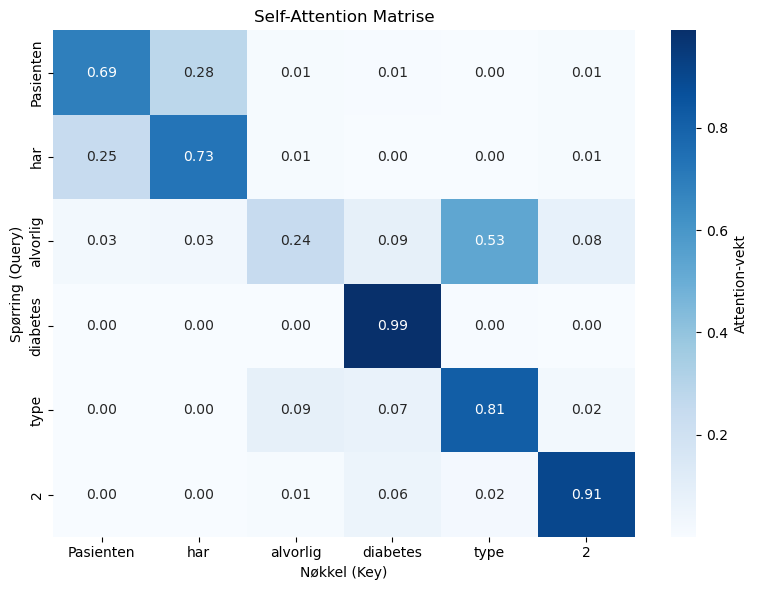

In [4]:
# Beregn full attention-matrise
def compute_attention_matrix(embeddings):
    """Beregn attention mellom alle par av ord."""
    n = len(embeddings)
    attention_matrix = np.zeros((n, n))
    
    for i in range(n):
        _, weights = simple_attention(embeddings[i], embeddings, embeddings)
        attention_matrix[i] = weights
    
    return attention_matrix

attention_matrix = compute_attention_matrix(word_embeddings)

# Visualiser som heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(attention_matrix, 
            xticklabels=words, 
            yticklabels=words,
            annot=True, 
            fmt='.2f',
            cmap='Blues',
            cbar_kws={'label': 'Attention-vekt'})
plt.title('Self-Attention Matrise')
plt.xlabel('Nøkkel (Key)')
plt.ylabel('Spørring (Query)')
plt.tight_layout()
plt.show()

### Refleksjon

> **Tenk over**: I en reell medisinsk kontekst, hvilke ordpar ville du forvente høy attention mellom?
> 
> For eksempel: "pasient" ↔ "diagnose", "medisin" ↔ "dose", "symptom" ↔ "behandling"

---

## 4. Multi-Head Attention

I praksis bruker transformers **multiple attention "heads"** som kan fokusere på ulike aspekter av input samtidig:

- **Head 1**: Grammatiske relasjoner (subjekt-verb)
- **Head 2**: Semantiske koblinger (symptom-diagnose)
- **Head 3**: Medisinsk terminologi (generisk navn-merkenavn)
- **Head 4**: Tidsrelasjoner (før-etter behandling)

Dette gir modellen rikere representasjoner.

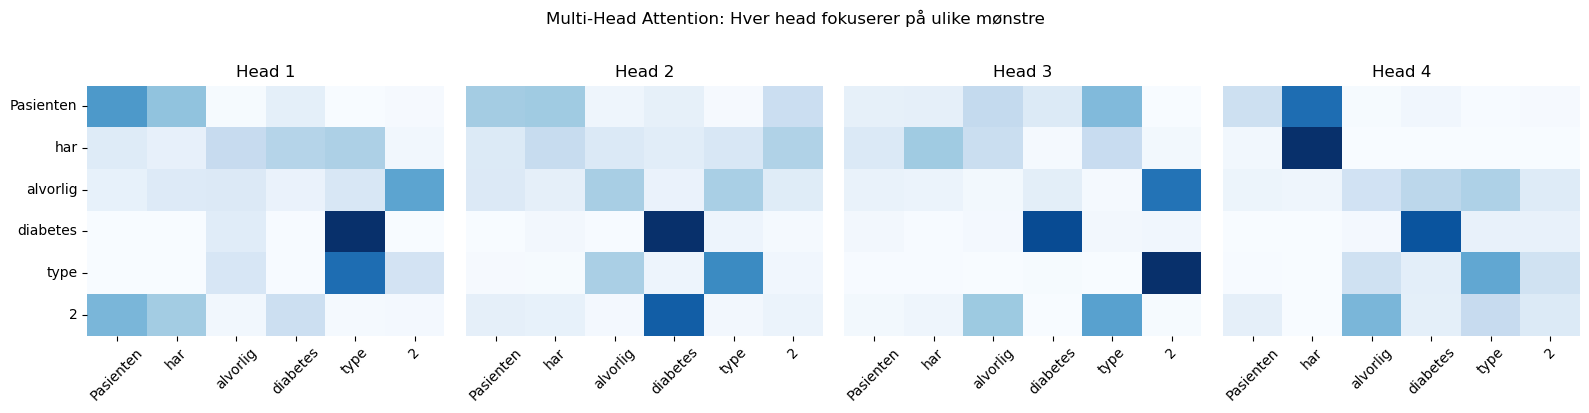

In [5]:
def multi_head_attention_demo(embeddings, n_heads=4):
    """
    Demonstrer multi-head attention med forskjellige tilfeldige projeksjoner.
    """
    n_words, d_model = embeddings.shape
    d_head = d_model  # Forenklet: samme dimensjon per head
    
    fig, axes = plt.subplots(1, n_heads, figsize=(16, 4))
    
    for h in range(n_heads):
        # Simuler forskjellige projeksjoner for hver head
        np.random.seed(h * 100)
        W_q = np.random.randn(d_model, d_head) * 0.5
        W_k = np.random.randn(d_model, d_head) * 0.5
        
        # Transformer embeddings
        Q = embeddings @ W_q
        K = embeddings @ W_k
        
        # Beregn attention for denne head
        scores = Q @ K.T
        attention = np.exp(scores) / np.exp(scores).sum(axis=1, keepdims=True)
        
        # Visualiser
        sns.heatmap(attention, ax=axes[h], cmap='Blues', 
                    xticklabels=words, yticklabels=words if h == 0 else False,
                    cbar=False)
        axes[h].set_title(f'Head {h+1}')
        axes[h].tick_params(axis='x', rotation=45)
    
    plt.suptitle('Multi-Head Attention: Hver head fokuserer på ulike mønstre', y=1.02)
    plt.tight_layout()
    plt.show()

multi_head_attention_demo(word_embeddings)

---

## 5. Transformer-blokken

En komplett transformer-blokk består av:

1. **Multi-Head Self-Attention**
2. **Add & Normalize** (residual connection + layer norm)
3. **Feed-Forward Network**
4. **Add & Normalize**

```
Input
  │
  ├──────────────────┐
  ↓                  │
Multi-Head Attention │
  ↓                  │
  + ←────────────────┘  (Residual Connection)
  ↓
Layer Norm
  │
  ├──────────────────┐
  ↓                  │
Feed-Forward Network │
  ↓                  │
  + ←────────────────┘  (Residual Connection)
  ↓
Layer Norm
  ↓
Output
```

In [6]:
if TORCH_AVAILABLE:
    class SimpleTransformerBlock(nn.Module):
        """Forenklet transformer-blokk for demonstrasjon."""
        
        def __init__(self, d_model=512, n_heads=8, d_ff=2048):
            super().__init__()
            self.attention = nn.MultiheadAttention(d_model, n_heads, batch_first=True)
            self.norm1 = nn.LayerNorm(d_model)
            self.norm2 = nn.LayerNorm(d_model)
            self.feed_forward = nn.Sequential(
                nn.Linear(d_model, d_ff),
                nn.ReLU(),
                nn.Linear(d_ff, d_model)
            )
        
        def forward(self, x):
            # Self-attention med residual connection
            attn_output, _ = self.attention(x, x, x)
            x = self.norm1(x + attn_output)
            
            # Feed-forward med residual connection
            ff_output = self.feed_forward(x)
            x = self.norm2(x + ff_output)
            
            return x

    # Demonstrer
    model = SimpleTransformerBlock(d_model=512, n_heads=8)
    n_params = sum(p.numel() for p in model.parameters())
    print(f"Transformer-blokk opprettet med {n_params:,} parametere")
    print(f"\nArkitektur:\n{model}")
else:
    print("PyTorch ikke tilgjengelig - hopper over transformer-blokk demo")

Transformer-blokk opprettet med 3,152,384 parametere

Arkitektur:
SimpleTransformerBlock(
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (feed_forward): Sequential(
    (0): Linear(in_features=512, out_features=2048, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2048, out_features=512, bias=True)
  )
)


### Skalering

Moderne språkmodeller stabler mange slike blokker:

| Modell | Blokker | Attention Heads | Parametere |
|--------|---------|-----------------|------------|
| BERT-base | 12 | 12 | 110M |
| GPT-2 | 12 | 12 | 117M |
| GPT-3 | 96 | 96 | 175B |
| GPT-4 | ~120? | ~96? | ~1.7T? |

---

## 6. Praktisk betydning for helsevesenet

Transformer-arkitekturen muliggjør mange viktige anvendelser:

### 1. Journalsammendrag
Attention lar modellen identifisere og fokusere på de viktigste delene av lange pasientjournaler.

### 2. Diagnosestøtte
Ved å koble symptomer til mulige diagnoser gjennom attention-mønstre.

### 3. Medisininteraksjoner
Oppdage potensielle legemiddelinteraksjoner ved å relatere medikamenter til hverandre.

### 4. Pasientkommunikasjon
Forklare medisinske termer på en forståelig måte ved å forstå kontekst.

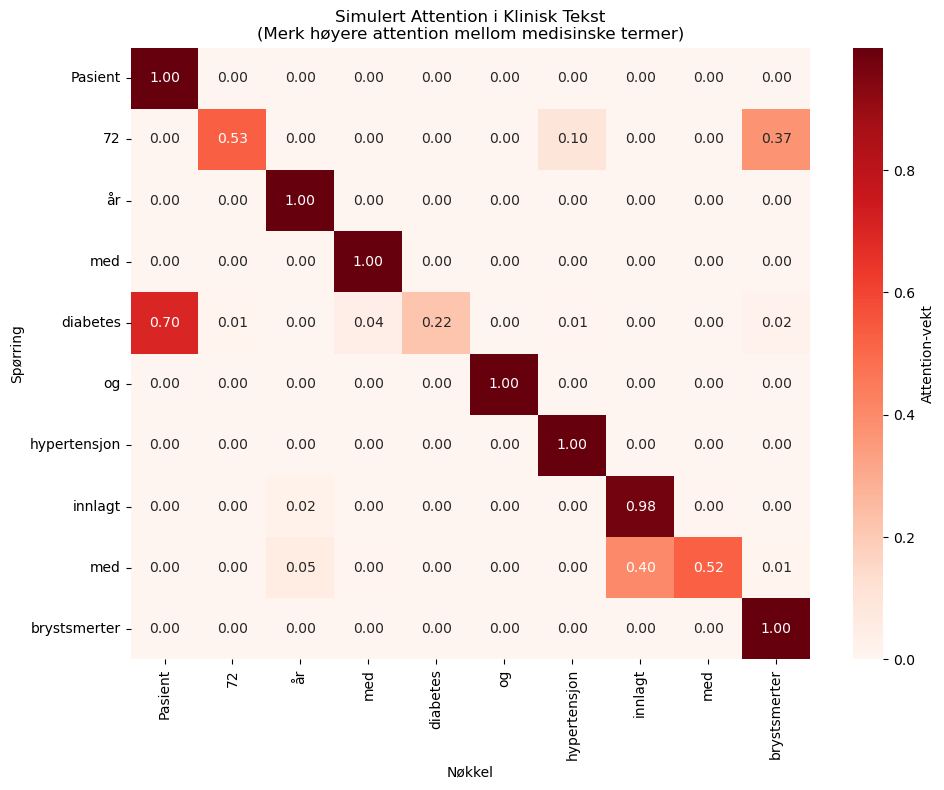

In [7]:
# Eksempel: Simuler attention i en klinisk kontekst
clinical_text = ["Pasient", "72", "år", "med", "diabetes", "og", "hypertensjon", 
                 "innlagt", "med", "brystsmerter"]

# Simuler at modellen har lært meningsfulle embeddings
# (i praksis ville dette være fra trening på millioner av dokumenter)
np.random.seed(123)
clinical_embeddings = np.random.randn(len(clinical_text), 8)

# Juster embeddings for å simulere meningsfulle relasjoner
# Symptom-relaterte ord (diabetes, hypertensjon, brystsmerter) bør ha høy attention til hverandre
symptom_indices = [4, 6, 9]  # diabetes, hypertensjon, brystsmerter
for i in symptom_indices:
    for j in symptom_indices:
        if i != j:
            clinical_embeddings[i] += 0.3 * clinical_embeddings[j]

# Beregn attention-matrise
clinical_attention = compute_attention_matrix(clinical_embeddings)

# Visualiser
plt.figure(figsize=(10, 8))
sns.heatmap(clinical_attention, 
            xticklabels=clinical_text, 
            yticklabels=clinical_text,
            annot=True, 
            fmt='.2f',
            cmap='Reds',
            cbar_kws={'label': 'Attention-vekt'})
plt.title('Simulert Attention i Klinisk Tekst\n(Merk høyere attention mellom medisinske termer)')
plt.xlabel('Nøkkel')
plt.ylabel('Spørring')
plt.tight_layout()
plt.show()

---

## Oppsummering

### Hovedpunkter

1. **Attention** lar modellen fokusere på relevante deler av input
2. **Self-attention** beregner relasjoner mellom alle ord i en sekvens
3. **Multi-head attention** fanger opp ulike typer relasjoner samtidig
4. **Transformer-blokker** kombinerer attention med feed-forward nettverk
5. **Skalering** av denne arkitekturen gir dagens kraftige språkmodeller

### Refleksjonsoppgaver

1. Hvorfor tror du attention-mekanismen er spesielt nyttig for medisinske tekster?
2. Hvilke utfordringer kan oppstå når man bruker attention på veldig lange dokumenter?
3. Hvordan kan visualisering av attention bidra til forklarbar AI i medisin?

---

*Neste notebook: [03 - LLM Grunnleggende](03-llm-grunnleggende.ipynb)*